In [48]:
# ==============================
# 1️⃣ Librerías y Conexión a BD
# ==============================
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px

# Configuración de plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

In [49]:
# Conexión a PostgreSQL
usuario = "postgres"
password = "dmx23"
host = "localhost"
base_datos = "crypto_db"

dsn = f"postgresql+psycopg2://{usuario}:{password}@{host}/{base_datos}"
engine = create_engine(dsn, connect_args={"options": "-c client_encoding=utf8"})

print("✅ Conexión a PostgreSQL lista")

✅ Conexión a PostgreSQL lista


In [50]:
# ==============================
# 2️⃣ Cargar datos desde BD
# ==============================
df_cryptos = pd.read_sql("SELECT * FROM crypto_prices", engine)
df_info = pd.read_sql("SELECT * FROM cryptocurrencies", engine)

print("✅ Datos cargados")
print("crypto_prices:", df_info.shape)
print("cryptocurrencies:", df_cryptos.shape)

✅ Datos cargados
crypto_prices: (10, 4)
cryptocurrencies: (820, 9)


In [51]:
print(df_cryptos.columns)
print(df_info.columns)

Index(['id', 'crypto_id', 'price_usd', 'market_cap_usd', 'volume_24h',
       'high_24h', 'low_24h', 'price_change_percentage_24h', 'snapshot_ts'],
      dtype='object')
Index(['id', 'name', 'symbol', 'last_seen_at'], dtype='object')


In [52]:
df = df_cryptos.merge(df_info, left_on="crypto_id", right_on="id", suffixes=("_prices", "_currencies"))
df.drop(columns=["crypto_id"], inplace=True)  # si hay colisión de IDs

df.head()


,id_prices,price_usd,market_cap_usd,volume_24h,high_24h,low_24h,price_change_percentage_24h,snapshot_ts,id_currencies,name,symbol,last_seen_at
0,1,116672.000000,2.322761e+12,5.112692e+10,117310.00,111764.000000,3.52294,2025-08-22 20:24:59.338227,bitcoin,Bitcoin,BTC,2025-08-23 14:28:08.617866
1,2,4785.440000,5.779226e+11,5.915255e+10,4877.09,4213.310000,12.65507,2025-08-22 20:24:59.354105,ethereum,Ethereum,ETH,2025-08-23 14:28:08.646942
2,3,3.020000,1.801965e+11,8.803128e+09,3.10,2.790000,5.91202,2025-08-22 20:24:59.357025,ripple,Xrp,XRP,2025-08-23 14:28:08.650346
3,4,0.999653,1.670921e+11,1.269798e+11,1.00,0.999658,-0.01044,2025-08-22 20:24:59.359939,tether,Tether,USDT,2025-08-23 14:28:08.653638
4,5,885.650000,1.235369e+11,2.462733e+09,899.77,841.330000,5.26149,2025-08-22 20:24:59.361739,binancecoin,Bnb,BNB,2025-08-23 14:28:08.654896


In [53]:
# ==============================
# Info General y Validacion de nulos
# ==============================
print(df.info())
print(df.describe().T)

# Valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id_prices                    820 non-null    int64         
 1   price_usd                    820 non-null    float64       
 2   market_cap_usd               820 non-null    float64       
 3   volume_24h                   820 non-null    float64       
 4   high_24h                     820 non-null    float64       
 5   low_24h                      820 non-null    float64       
 6   price_change_percentage_24h  820 non-null    float64       
 7   snapshot_ts                  820 non-null    datetime64[ns]
 8   id_currencies                820 non-null    object        
 9   name                         820 non-null    object        
 10  symbol                       820 non-null    object        
 11  last_seen_at                 820 non-null    

id_prices                      0
price_usd                      0
market_cap_usd                 0
volume_24h                     0
high_24h                       0
low_24h                        0
price_change_percentage_24h    0
snapshot_ts                    0
id_currencies                  0
name                           0
symbol                         0
last_seen_at                   0
dtype: int64

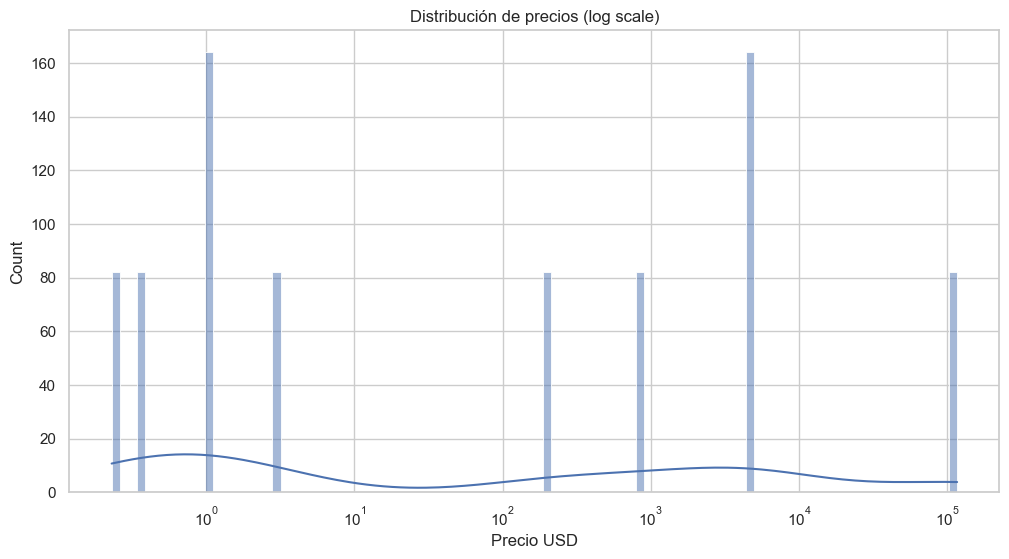

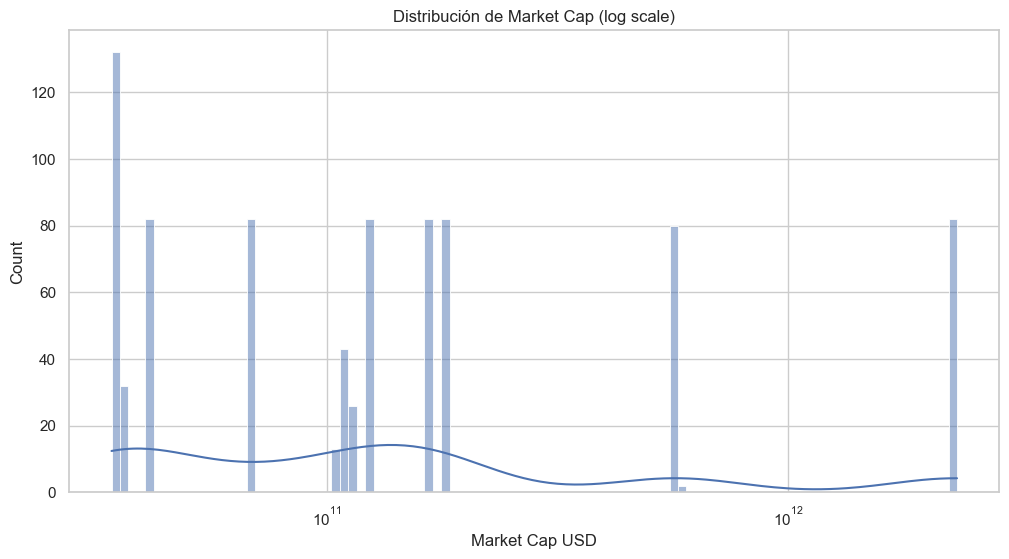

In [54]:
# ==============================
# Distribución de precios y market cap
# ==============================

plt.figure(figsize=(12,6))
sns.histplot(df["price_usd"], bins=100, log_scale=True, kde=True)
plt.title("Distribución de precios (log scale)")
plt.xlabel("Precio USD")
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(df["market_cap_usd"], bins=100, log_scale=True, kde=True)
plt.title("Distribución de Market Cap (log scale)")
plt.xlabel("Market Cap USD")
plt.show()

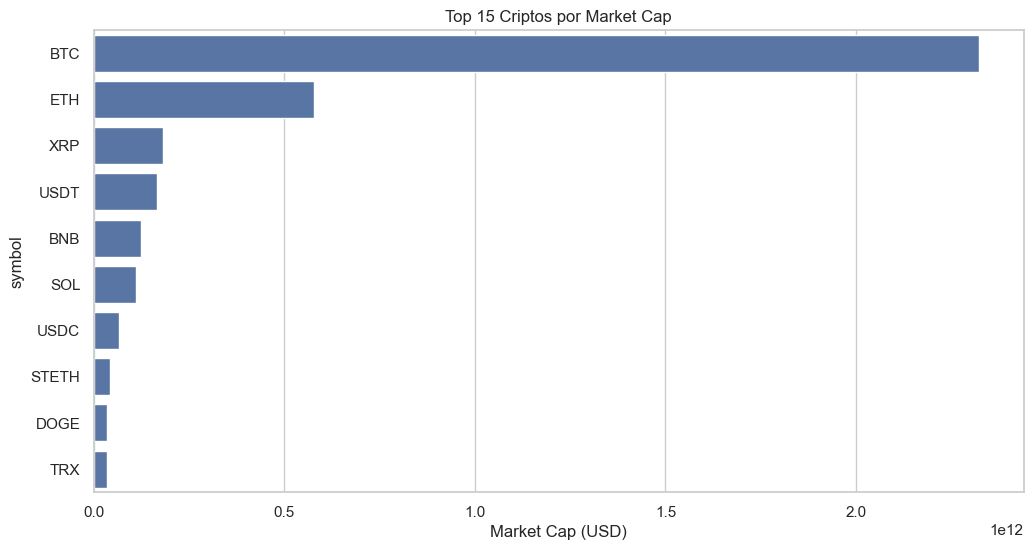

In [55]:
# ==============================
# Ranking de criptos por capitalización de mercado
# ==============================

top_marketcap = df.groupby("symbol")["market_cap_usd"].max().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_marketcap.values, y=top_marketcap.index)
plt.title("Top 15 Criptos por Market Cap")
plt.xlabel("Market Cap (USD)")
plt.show()

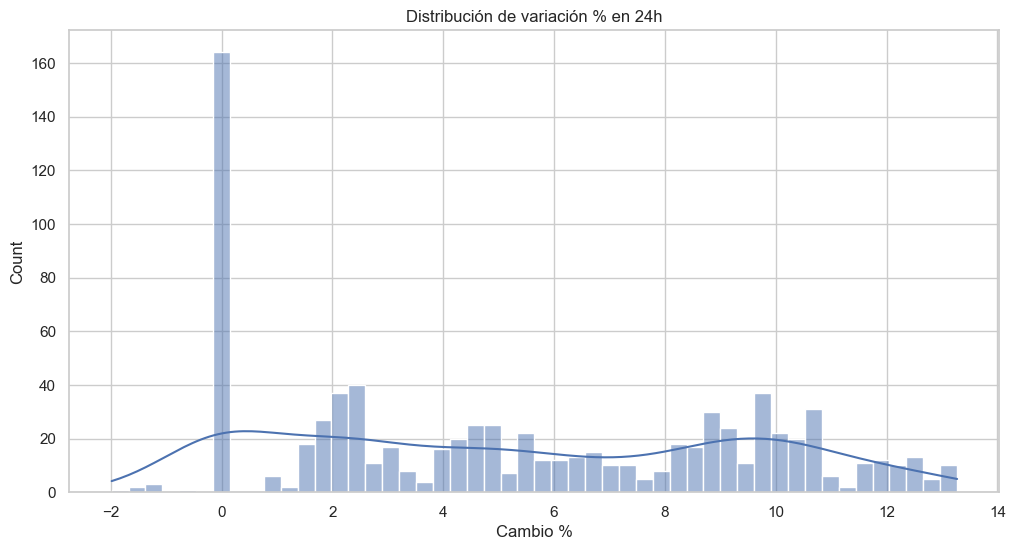

symbol
SOL      10.310451
ETH      10.190045
STETH    10.153771
DOGE      7.871582
XRP       5.729819
BNB       4.317973
BTC       2.426390
TRX       1.901349
USDC      0.000095
USDT     -0.022454
Name: price_change_percentage_24h, dtype: float64


In [56]:
# ==============================
# Volatilidad (cambio % en 24h)
# ==============================

plt.figure(figsize=(12,6))
sns.histplot(df["price_change_percentage_24h"], bins=50, kde=True)
plt.title("Distribución de variación % en 24h")
plt.xlabel("Cambio %")
plt.show()

# Criptos más volátiles
volatility = df.groupby("symbol")["price_change_percentage_24h"].mean().sort_values(ascending=False).head(10)
print(volatility)

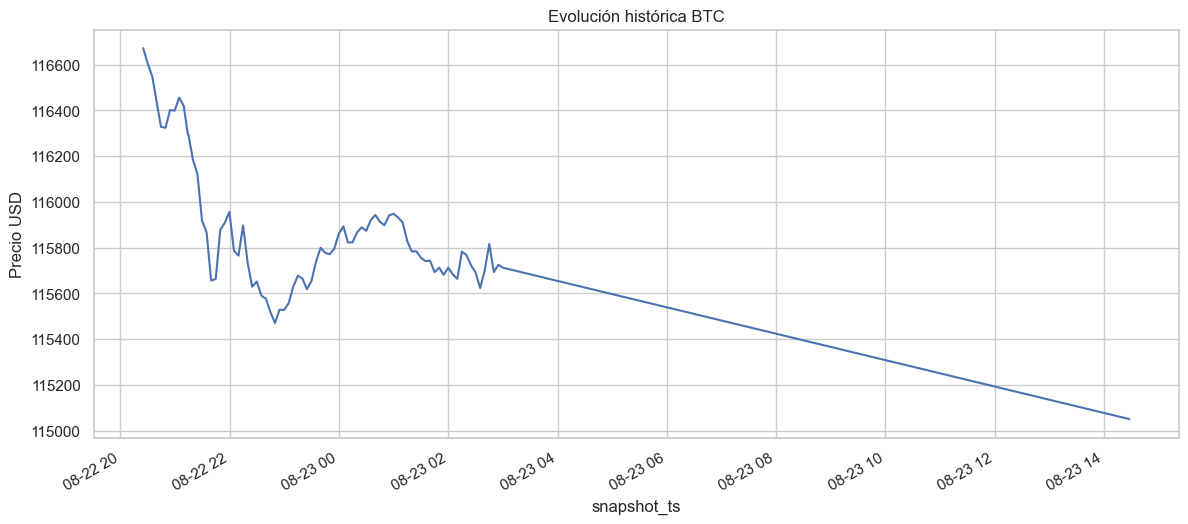

In [57]:
# ==============================
# Series temporales (evolución histórica)
# ==============================

# Asegurar formato de fecha
df["snapshot_ts"] = pd.to_datetime(df["snapshot_ts"])

# Ejemplo: evolución de BTC
btc = df[df["symbol"]=="BTC"].set_index("snapshot_ts").sort_index()

plt.figure(figsize=(14,6))
btc["price_usd"].plot()
plt.title("Evolución histórica BTC")
plt.ylabel("Precio USD")
plt.show()


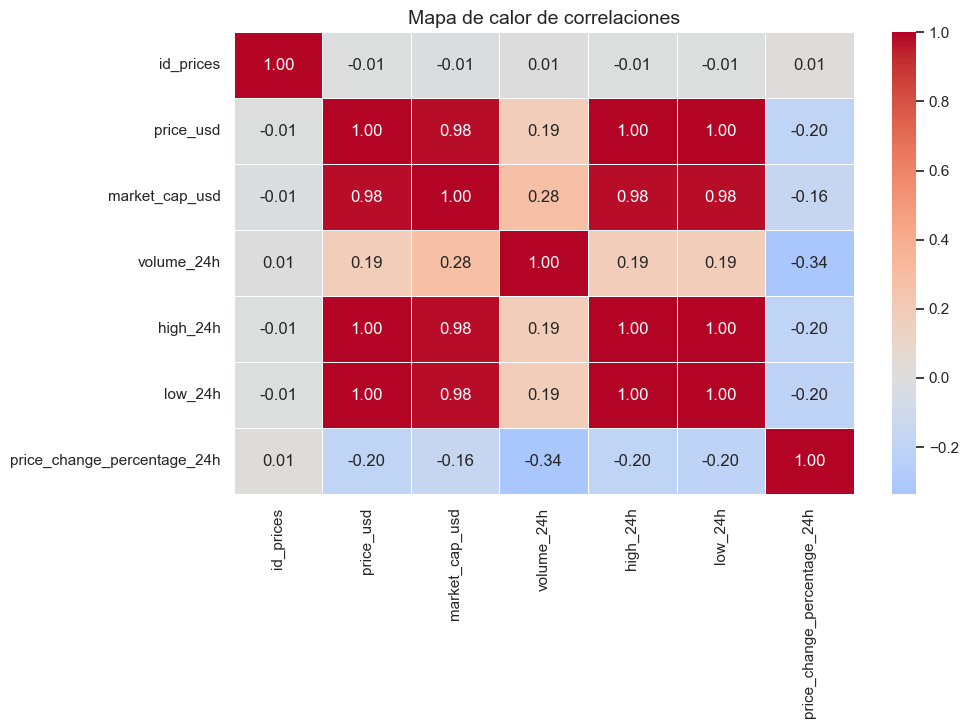

In [58]:
# ==============================
# Correlaciones entre precios
# ==============================
df_copy = df.copy()

# Filtrar solo variables numéricas
num_df = df_copy.select_dtypes(include=['float64', 'int64'])

# Eliminar columnas constantes (sin varianza)
num_df = num_df.loc[:, num_df.std() > 0]

# Calcular la matriz de correlación
corr = num_df.corr()

# Heatmap de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Mapa de calor de correlaciones", fontsize=14)
plt.show()


In [59]:
# ==============================
# Analisis variables descriptivas
# ==============================

df.describe(include="all")

,id_prices,price_usd,market_cap_usd,volume_24h,high_24h,low_24h,price_change_percentage_24h,snapshot_ts,id_currencies,name,symbol,last_seen_at
count,820.000000,820.000000,8.200000e+02,8.200000e+02,820.000000,820.000000,820.000000,820,820,820,820,820
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,10,10,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bitcoin,Bitcoin,BTC,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,82,82,NaN
mean,410.500000,12639.995072,3.636389e+11,2.982245e+10,12815.465448,12125.275525,5.287902,2025-08-22 23:51:18.431159552,NaN,NaN,NaN,2025-08-23 14:28:08.652022528
min,1.000000,0.230034,3.413284e+10,6.778604e+07,0.241713,0.209124,-1.984790,2025-08-22 20:24:59.338227,NaN,NaN,NaN,2025-08-23 14:28:08.617866
25%,205.750000,0.999541,4.153553e+10,2.506349e+09,0.999967,0.999511,1.893675,2025-08-22 21:59:39.429558272,NaN,NaN,NaN,2025-08-23 14:28:08.650345984
50%,410.500000,99.435000,1.172811e+11,1.039612e+10,102.360000,90.375000,4.804040,2025-08-22 23:42:18.508142080,NaN,NaN,NaN,2025-08-23 14:28:08.655451904
75%,615.250000,4703.890000,1.797319e+11,5.268326e+10,4861.100000,4201.030000,9.103063,2025-08-23 01:24:55.905560320,NaN,NaN,NaN,2025-08-23 14:28:08.659554048
max,820.000000,116672.000000,2.322900e+12,1.363450e+11,117310.000000,114583.000000,13.271440,2025-08-23 14:28:08.662957,NaN,NaN,NaN,2025-08-23 14:28:08.662131


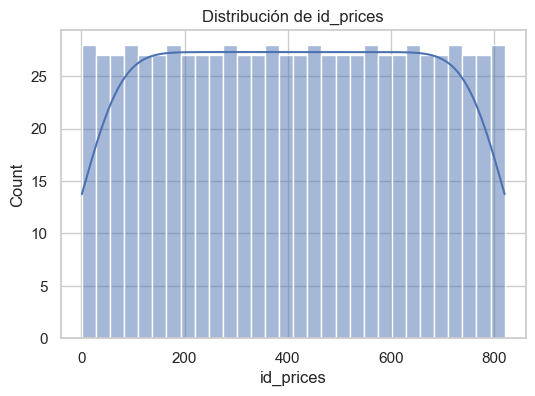

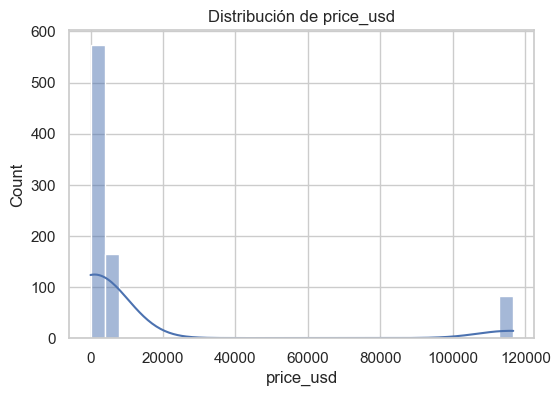

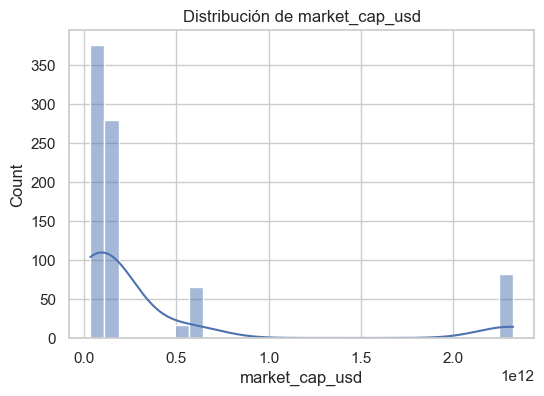

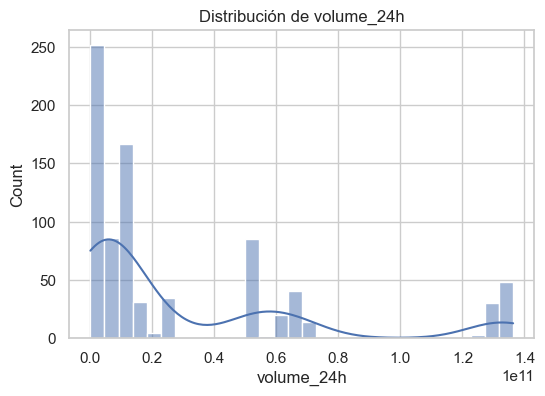

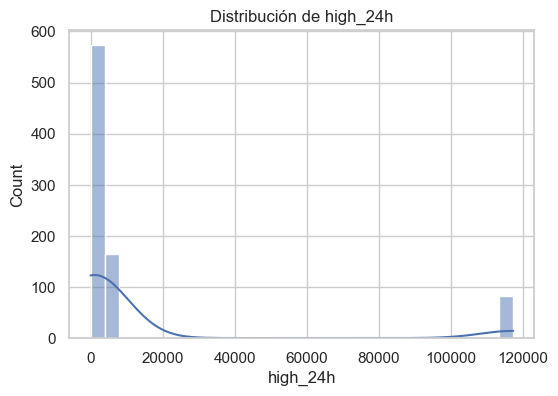

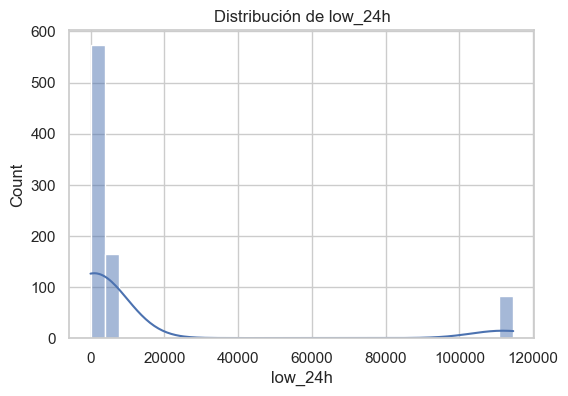

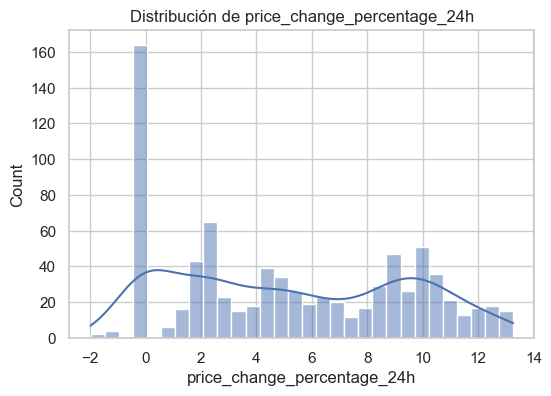

In [60]:
# ==============================
# Distribución de variables
# ==============================

for col in num_df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.show()


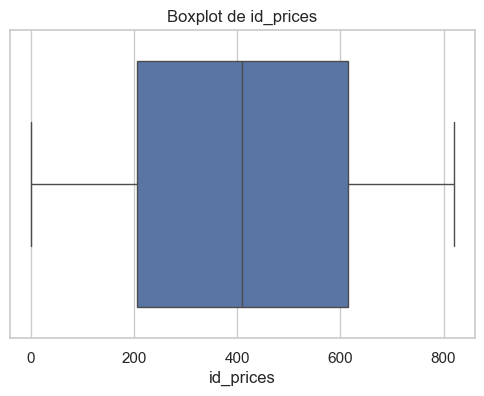

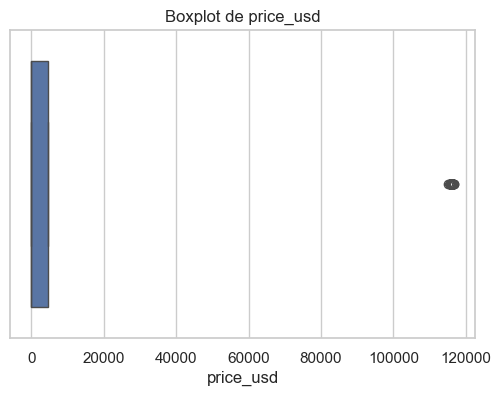

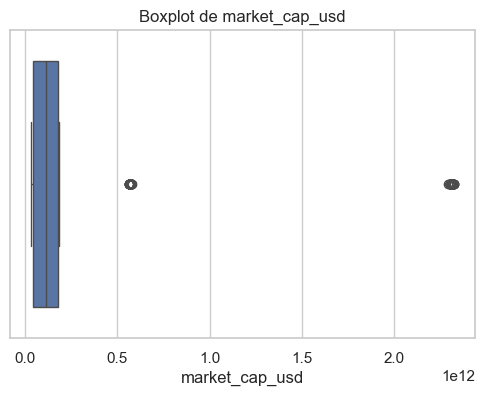

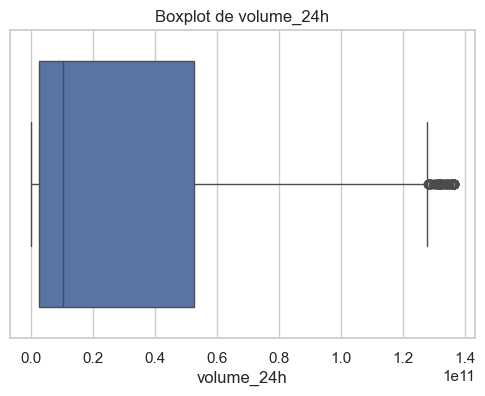

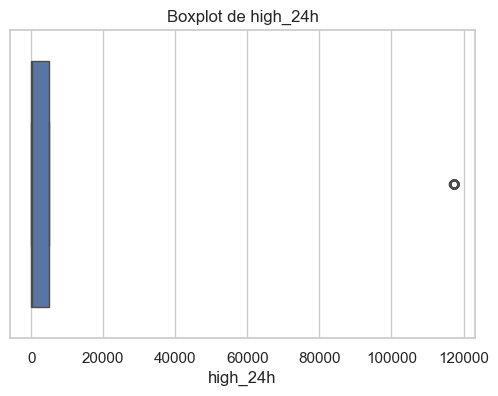

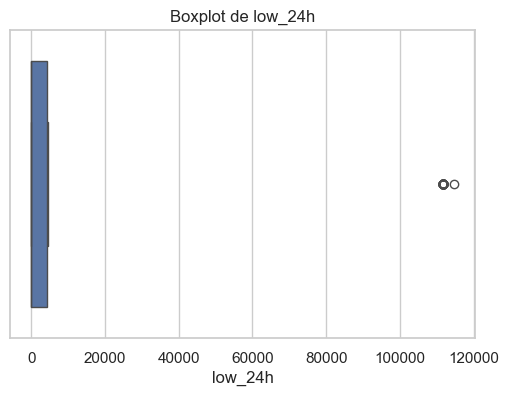

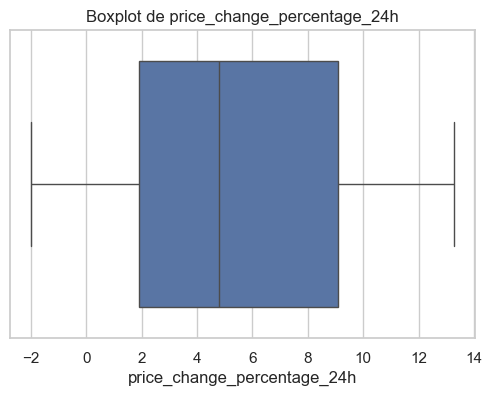

In [61]:
# ==============================
# Outliers (valores atípicos)
# ==============================

for col in num_df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()



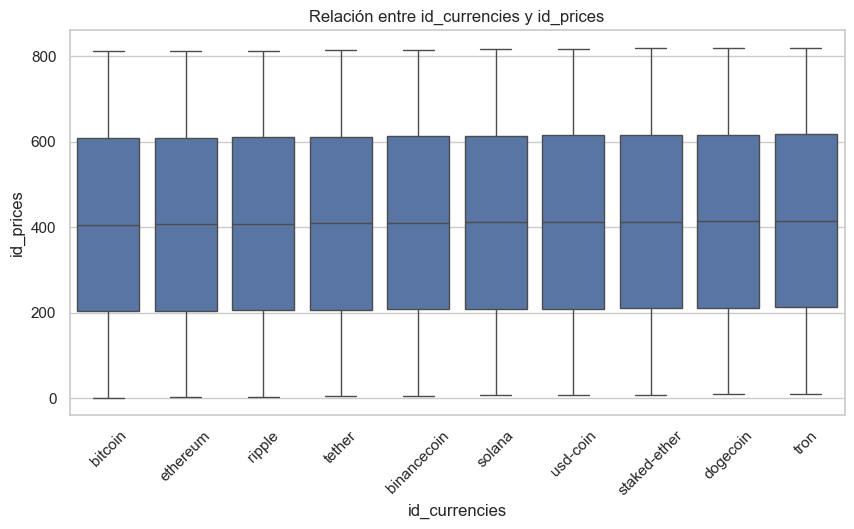

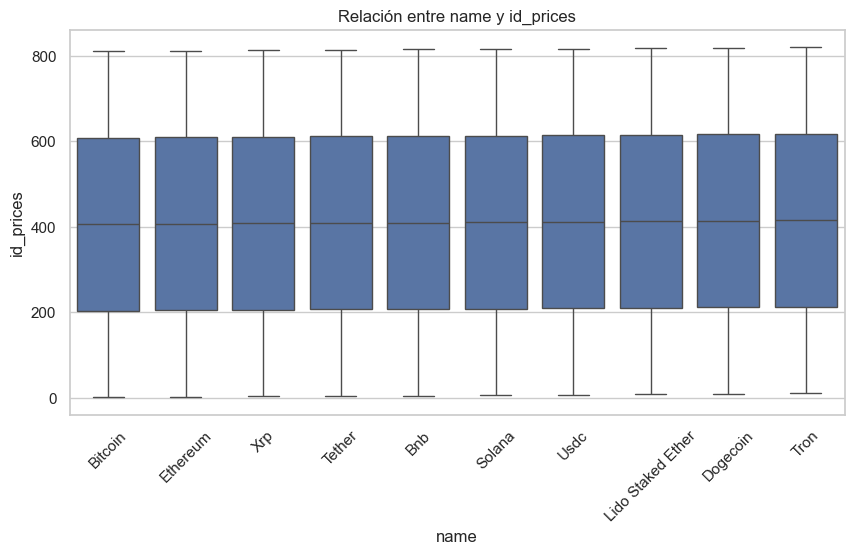

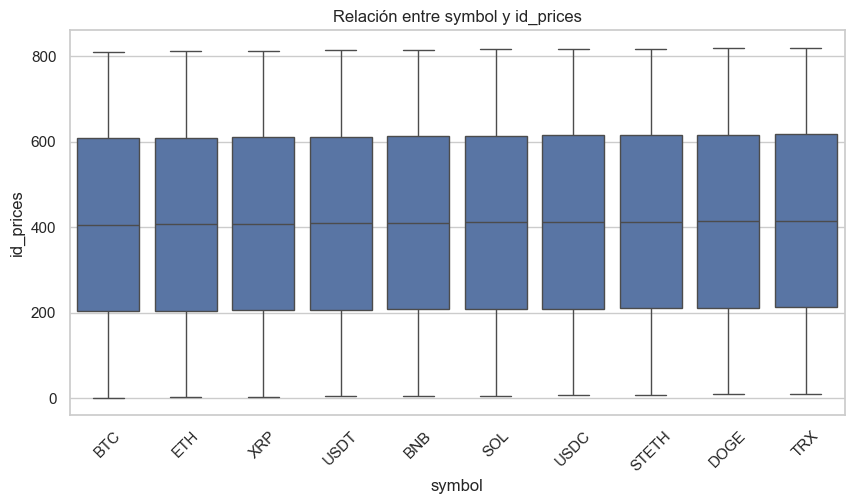

In [62]:
# ==============================
# Outliers (valores atípicos)
# ==============================

for col in df.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=df[col], y=df[num_df.columns[0]])  # ejemplo con primera variable numérica
    plt.xticks(rotation=45)
    plt.title(f"Relación entre {col} y {num_df.columns[0]}")
    plt.show()
